In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the GPT-2 and Roberta embeddings (as floats)
gpt2 = np.load('gpt2.npy').astype(float)
roberta = np.load('Roberta.npy').astype(float)

In [3]:
# Verify the shape of these arrays
print(f"GPT-2 shape: {gpt2.shape}")
print(f"RoBERTa shape: {roberta.shape}")

GPT-2 shape: (4734, 1600)
RoBERTa shape: (4734, 1024)


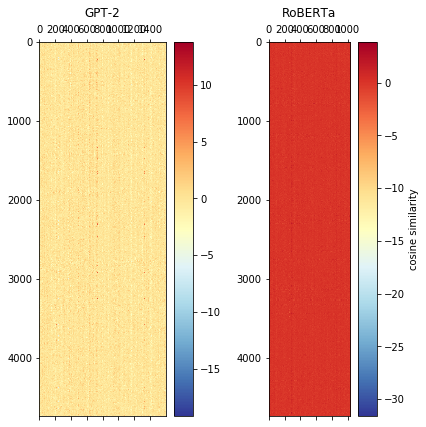

In [4]:
# Visualize these arrays
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(6, 6))
p0 = axs[0].matshow(gpt2, cmap='RdYlBu_r')
axs[0].set_title('GPT-2')
p1 = axs[1].matshow(roberta, cmap='RdYlBu_r')
axs[1].set_title('RoBERTa')
fig.colorbar(p0, ax=axs[0])
fig.colorbar(p1, ax=axs[1],
             label='cosine similarity')
plt.tight_layout()

In [5]:
# Scales look pretty different so let's z-score features
from scipy.stats import zscore
gpt2 = zscore(gpt2, axis=0)
roberta = zscore(roberta, axis=0)

In [6]:
# First we'll try simple orthogonal Procrustes
from scipy.linalg import orthogonal_procrustes

In [7]:
# Function to horizontal-pad zeros on a smaller array
def hpad_zeros(a, target_dim):
    assert a.shape[1] < target_dim
    zeros = np.zeros((a.shape[0],
                      target_dim - a.shape[1]))
    padded = np.hstack((a, zeros))
    return padded   

In [8]:
# Pad zeros onto RoBERTa dataset to match GPT-2
roberta_pad = hpad_zeros(roberta, gpt2.shape[1])

In [9]:
# Get the othorgonal Procrustes matrix
ort, sv = orthogonal_procrustes(gpt2, roberta_pad)

In [10]:
# Align GPT-2 to RoBERTa
gpt2_procrustes = gpt2.dot(ort)

In [11]:
# Compute within-model representational geometry before/after
from scipy.spatial.distance import pdist, squareform
gpt2_original_rdm = squareform(pdist(gpt2, metric='cosine'))
gpt2_procrustes_rdm = squareform(pdist(gpt2_procrustes, metric='cosine'))
roberta_rdm = squareform(pdist(roberta, metric='cosine'))

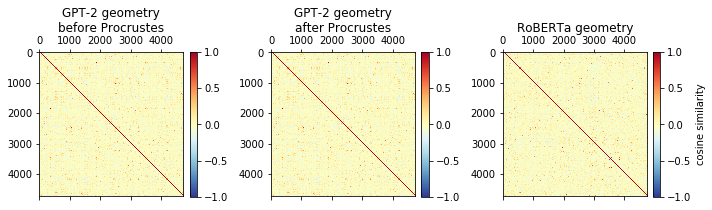

In [12]:
# Visualize representational before and after Procrustes
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 6))
p0 = axs[0].matshow(1 - gpt2_original_rdm,
                    vmin=-1, vmax=1, cmap='RdYlBu_r')
axs[0].set_title('GPT-2 geometry\nbefore Procrustes',
                 y=1.1)
p1 = axs[1].matshow(1 - gpt2_procrustes_rdm,
                    vmin=-1, vmax=1, cmap='RdYlBu_r')
axs[1].set_title('GPT-2 geometry\nafter Procrustes',
                 y=1.1)
p2 = axs[2].matshow(1 - roberta_rdm,
                    vmin=-1, vmax=1, cmap='RdYlBu_r')
axs[2].set_title('RoBERTa geometry',
                 y=1.1)
fig.colorbar(p0, ax=axs[0], fraction=0.046, pad=0.04)
fig.colorbar(p1, ax=axs[1], fraction=0.046, pad=0.04)
fig.colorbar(p2, ax=axs[2], fraction=0.046, pad=0.04,
             label='cosine similarity')
plt.tight_layout()

In [13]:
# Check the correlation between original GPT-2 and RoBERTa geometries
from scipy.stats import pearsonr
print("Correlation between GPT-2 and RoBERTa geometries: "
      f"{round(pearsonr(squareform(gpt2_original_rdm), squareform(roberta_rdm))[0], 3)}")

Correlation between GPT-2 and RoBERTa geometries: 0.387


In [14]:
# Compute sample-wise distances between datasets
from scipy.spatial.distance import cdist
original_dist = cdist(gpt2, roberta_pad, metric='cosine')
procrustes_dist = cdist(gpt2_procrustes, roberta_pad, metric='cosine')

In [15]:
# Get sample-wise cosine similarities
print(f"Cosine similarity before Procrustes: {1 - np.mean(original_dist.diagonal())}")
print(f"Cosine similarity after Procrustes: {1 - np.mean(procrustes_dist.diagonal())}")

Cosine similarity before Procrustes: 0.00043525052574167056
Cosine similarity after Procrustes: 0.5606790232019736


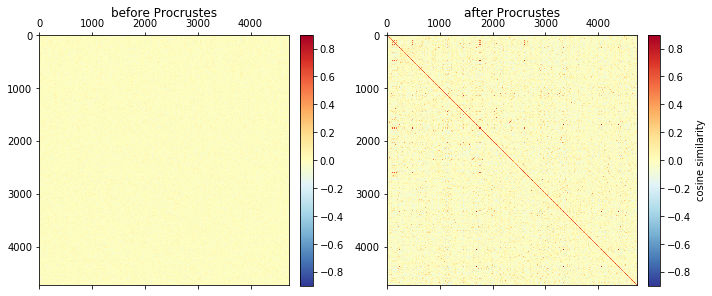

In [16]:
# Visualize sample-wise alignment before and after
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))
p0 = axs[0].matshow(1 - original_dist,
                    vmin=-.9, vmax=.9, cmap="RdYlBu_r")
axs[0].set_title('before Procrustes')
p1 = axs[1].matshow(1 - procrustes_dist,
                    vmin=-.9, vmax=.9, cmap="RdYlBu_r")
axs[1].set_title('after Procrustes')
fig.colorbar(p0, ax=axs[0], fraction=0.046, pad=0.04)
fig.colorbar(p1, ax=axs[1], fraction=0.046, pad=0.04,
             label='cosine similarity')
plt.tight_layout()

In [17]:
# Now let's try SRM
from brainiak.funcalign.srm import SRM

In [18]:
# Fit SRM with arbitrary 100 features
n_features = 100
srm = SRM(n_iter=10, features=n_features)
srm.fit([gpt2.T, roberta.T])

SRM(comm=<mpi4py.MPI.Intracomm object at 0x10abf3d90>, features=100, n_iter=10,
    rand_seed=0)

In [19]:
# Transform the data into shared space using SRM transformations
gpt2_srm = gpt2.dot(srm.w_[0])
roberta_srm = roberta.dot(srm.w_[1])

In [20]:
# Compute within-model representational geometry before/after
gpt2_srm_rdm = squareform(pdist(gpt2_srm, metric='cosine'))
roberta_srm_rdm = squareform(pdist(roberta_srm, metric='cosine'))

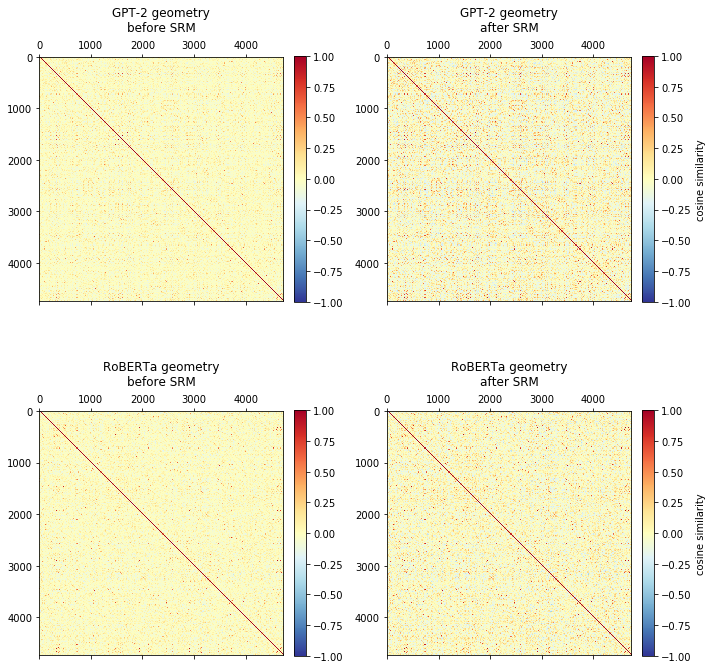

In [21]:
# Visualize representational geometry before and after SRM
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
p0 = axs[0][0].matshow(1 - gpt2_original_rdm,
                       vmin=-1, vmax=1, cmap="RdYlBu_r")
axs[0][0].set_title('GPT-2 geometry\nbefore SRM',
                    y=1.08)
p1 = axs[0][1].matshow(1 - gpt2_srm_rdm,
                       vmin=-1, vmax=1, cmap="RdYlBu_r")
axs[0][1].set_title('GPT-2 geometry\nafter SRM',
                    y=1.08)
p2 = axs[1][0].matshow(1 - roberta_rdm,
                       vmin=-1, vmax=1, cmap="RdYlBu_r")
axs[1][0].set_title('RoBERTa geometry\nbefore SRM',
                    y=1.08)
p3 = axs[1][1].matshow(1 - roberta_srm_rdm,
                       vmin=-1, vmax=1, cmap="RdYlBu_r")
axs[1][1].set_title('RoBERTa geometry\nafter SRM',
                    y=1.08)
fig.colorbar(p0, ax=axs[0][0], fraction=0.046, pad=0.04)
fig.colorbar(p1, ax=axs[0][1], fraction=0.046, pad=0.04,
             label='cosine similarity')
fig.colorbar(p2, ax=axs[1][0], fraction=0.046, pad=0.04)
fig.colorbar(p3, ax=axs[1][1], fraction=0.046, pad=0.04,
             label='cosine similarity')
plt.tight_layout()

In [22]:
# Evaluate similarity of within-model RDMs before/after SRM
print(f"Correlation between GPT-2 geometry before/after SRM (k = {n_features}): "
      f"{round(pearsonr(squareform(gpt2_original_rdm), squareform(gpt2_srm_rdm))[0], 3)}")
print(f"Correlation between RoBERTa geometry before/after SRM (k = {n_features}): "
      f"{round(pearsonr(squareform(roberta_rdm), squareform(roberta_srm_rdm))[0], 3)}")

Correlation between GPT-2 geometry before/after SRM (k = 100): 0.96
Correlation between RoBERTa geometry before/after SRM (k = 100): 0.967


In [23]:
# Compute sample-wise distances between datasets
srm_dist = cdist(gpt2_srm, roberta_srm, metric='cosine')

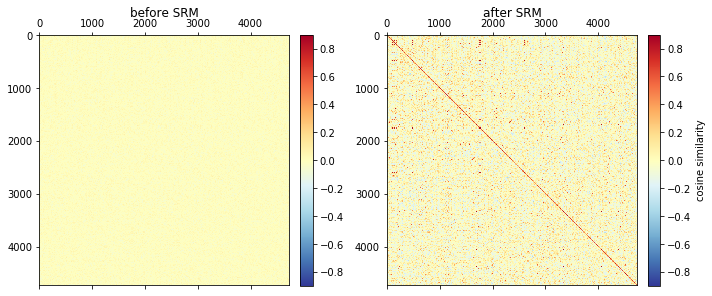

In [24]:
# Visualize sample-wise alignment before and after
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))
p0 = axs[0].matshow(1 - original_dist, vmin=-.9, vmax=.9,
                    cmap="RdYlBu_r")
axs[0].set_title('before SRM')
p1 = axs[1].matshow(1 - srm_dist, vmin=-.9, vmax=.9,
                    cmap="RdYlBu_r")
axs[1].set_title('after SRM')
fig.colorbar(p0, ax=axs[0], fraction=0.046, pad=0.04)
fig.colorbar(p1, ax=axs[1], fraction=0.046, pad=0.04,
             label='cosine similarity')
plt.tight_layout()

In [25]:
# Get sample-wise cosine similarities
print(f"Cosine similarity before SRM: {1 - np.mean(original_dist.diagonal())}")
print(f"Cosine similarity after SRM: {1 - np.mean(srm_dist.diagonal())}")

Cosine similarity before SRM: 0.00043525052574167056
Cosine similarity after SRM: 0.5964059143782843


In [26]:
# Now let's trying splitting the original data to avoid overfitting
gpt2 = np.load('gpt2.npy').astype(float)
roberta = np.load('Roberta.npy').astype(float)

# Start easy with split half
gpt2_train, gpt2_test = gpt2[:len(gpt2)//2], gpt2[len(gpt2)//2:]
roberta_train, roberta_test = roberta[:len(gpt2)//2], roberta[len(gpt2)//2:]

In [27]:
# Let's make a cute cross-validated z-score function
def zscore_cv(train, test):
    train_mean = np.mean(train, axis=0)
    train_std = np.std(train, axis=0)
    
    train_z = (train - train_mean) / train_std
    test_z = (test - train_mean) / train_std
    
    return train_z, test_z

In [28]:
# Z-score our split data
gpt2_train, gpt2_test = zscore_cv(gpt2_train, gpt2_test)
roberta_train, roberta_test = zscore_cv(roberta_train, roberta_test)

In [29]:
# Fit SRM (k = 100) on our training set
n_features = 100
srm = SRM(n_iter=10, features=n_features)
srm.fit([gpt2_train.T, roberta_train.T])

SRM(comm=<mpi4py.MPI.Intracomm object at 0x10abf3d90>, features=100, n_iter=10,
    rand_seed=0)

In [30]:
# Transform the test data into shared space using SRM transformations
gpt2_test_srm = gpt2_test.dot(srm.w_[0])
roberta_test_srm = roberta_test.dot(srm.w_[1])

In [31]:
# Evaluate similarity of within-model RDMs before/after SRM
gpt2_test_orig_rdm = squareform(pdist(gpt2_test, metric='cosine'))
roberta_test_orig_rdm = squareform(pdist(roberta_test, metric='cosine'))
gpt2_test_srm_rdm = squareform(pdist(gpt2_test_srm, metric='cosine'))
roberta_test_srm_rdm = squareform(pdist(roberta_test_srm, metric='cosine'))

print(f"Correlation between GPT-2 geometry before/after SRM (k = {n_features}): "
      f"{round(pearsonr(squareform(gpt2_test_orig_rdm), squareform(gpt2_test_srm_rdm))[0], 3)}")
print(f"Correlation between RoBERTa geometry before/after SRM (k = {n_features}): "
      f"{round(pearsonr(squareform(roberta_test_orig_rdm), squareform(roberta_test_srm_rdm))[0], 3)}")

Correlation between GPT-2 geometry before/after SRM (k = 100): 0.936
Correlation between RoBERTa geometry before/after SRM (k = 100): 0.951


In [32]:
# Evaluate similarity of geometry between models
print(f"Correlation between original GPT-2 and RoBERTa geometries: "
      f"{round(pearsonr(squareform(gpt2_test_orig_rdm), squareform(roberta_test_orig_rdm))[0], 3)}")
print(f"Correlation between GPT-2 and RoBERTa geometries after SRM (k = {n_features}): "
      f"{round(pearsonr(squareform(gpt2_test_srm_rdm), squareform(roberta_test_srm_rdm))[0], 3)}")

Correlation between original GPT-2 and RoBERTa geometries: 0.391
Correlation between GPT-2 and RoBERTa geometries after SRM (k = 100): 0.363


In [33]:
# Compute sample-wise distances between datasets
roberta_test_pad = hpad_zeros(roberta_test, gpt2_test.shape[1])
test_dist = cdist(gpt2_test, roberta_test_pad, metric='cosine')
srm_test_dist = cdist(gpt2_test_srm, roberta_test_srm, metric='cosine')

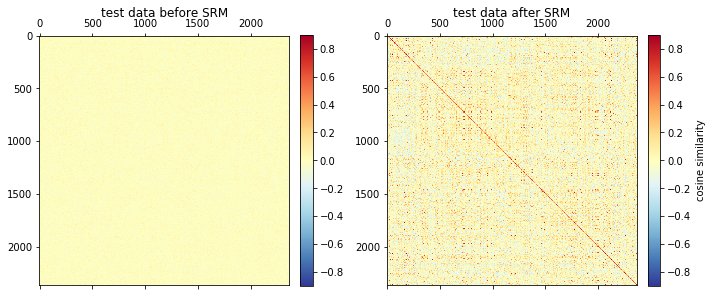

In [34]:
# Visualize sample-wise alignment before and after
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))
p0 = axs[0].matshow(1 - test_dist, vmin=-.9, vmax=.9,
                    cmap="RdYlBu_r")
axs[0].set_title('test data before SRM')
p1 = axs[1].matshow(1 - srm_test_dist, vmin=-.9, vmax=.9,
                    cmap="RdYlBu_r")
axs[1].set_title('test data after SRM')
fig.colorbar(p0, ax=axs[0], fraction=0.046, pad=0.04)
fig.colorbar(p1, ax=axs[1], fraction=0.046, pad=0.04,
             label='cosine similarity')
plt.tight_layout()

In [35]:
print(np.amin(srm_test_dist), np.amax(srm_test_dist))

0.08387915151962777 1.4729881923594919


In [36]:
# Get sample-wise cosine similarities
print(f"Cosine similarity before SRM (test data): {1 - np.mean(test_dist.diagonal())}")
print(f"Cosine similarity after SRM (test data): {1 - np.mean(srm_test_dist.diagonal())}")

Cosine similarity before SRM (test data): 0.0012865659799093931
Cosine similarity after SRM (test data): 0.49919318056889705


In [37]:
# Evaluate SRM at varying dimensionality k
k_grid = [10, 20, 50, 100, 200, 500, 1000]
srm_recons = {'gpt2': {}, 'roberta': {}}
for k in k_grid:
    srm = SRM(n_iter=10, features=k)
    srm.fit([gpt2_train.T, roberta_train.T])
    srm_recons['gpt2'][k] = gpt2_test.dot(srm.w_[0]).dot(srm.w_[0].T)
    srm_recons['roberta'][k] = roberta_test.dot(srm.w_[1]).dot(srm.w_[1].T)
    print(f"Finished running SRM(s) at k = {k}")

Finished running SRM(s) at k = 10
Finished running SRM(s) at k = 20
Finished running SRM(s) at k = 50
Finished running SRM(s) at k = 100
Finished running SRM(s) at k = 200
Finished running SRM(s) at k = 500
Finished running SRM(s) at k = 1000


In [38]:
# Compute the correlation between original and reconstructed embeddings
from brainiak.utils.utils import array_correlation
gpt2_recon_corr = []
roberta_recon_corr = []
for k in k_grid:
    gpt2_recon_corr.append(np.mean(
        array_correlation(gpt2_test,
                          srm_recons['gpt2'][k], axis=1)))
    roberta_recon_corr.append(np.mean(
        array_correlation(roberta_test,
                          srm_recons['roberta'][k], axis=1)))

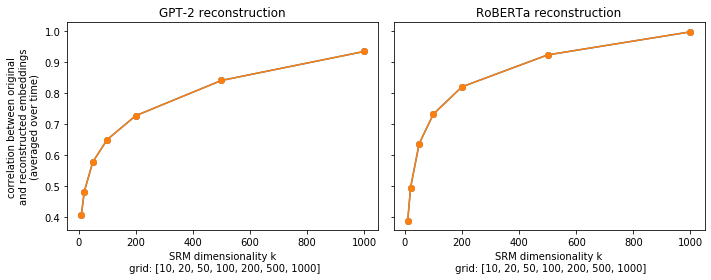

In [39]:
# Plot reconstruction curves
fig, axs = plt.subplots(ncols=2, figsize=(10, 4),
                        sharey=True)
axs[0].plot(k_grid, gpt2_recon_corr, 'o-')
axs[0].plot(k_grid, gpt2_recon_corr, 'o-')
axs[0].set_xlabel(f'SRM dimensionality k\n grid: {k_grid}')
axs[0].set_ylabel('correlation between original\nand '
                  'reconstructed embeddings\n(averaged over time)')
axs[0].set_title('GPT-2 reconstruction')
axs[1].plot(k_grid, roberta_recon_corr, 'o-')
axs[1].plot(k_grid, roberta_recon_corr, 'o-')
axs[1].set_xlabel(f'SRM dimensionality k\n grid: {k_grid}')
axs[1].set_title('RoBERTa reconstruction')
plt.tight_layout()